# Baseline models for Power consumption forecasting 

- naive
- seasonal naive
- random walk
- random walk with drift
- 2 week ahead forecast

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(xts)
library(fpp2)
library(forecast)
library(DMwR)
library(Metrics)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: forecast
Loading required package: fma
Loading required package: expsmooth
Loading required package: lattice
Loading required package: grid

Attaching package: ‘DMwR’

The following object is masked from ‘package:fma’:

    sales


Attaching package: ‘Metrics’

The following object is masked from ‘package:forecast’:

    accuracy



In [2]:
options(repr.plot.width=8, repr.plot.height=4)

## 1. Data import

In [3]:
path <- '../data/power-consumption/processed_data.csv'
data <- read_csv(path)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  Global_active_power = col_double(),
  Global_reactive_power = col_double(),
  Voltage = col_double(),
  Global_intensity = col_double(),
  Sub_metering_1 = col_double(),
  Sub_metering_2 = col_double(),
  Sub_metering_3 = col_double(),
  Sub_metering_4 = col_double(),
  Month = col_double(),
  Weekday = col_double(),
  WeekOfYear = col_double(),
  Median_active_power = col_double(),
  Lagged_active_power = col_double(),
  median_residual = col_double()
)


In [4]:
head(data)
tail(data)
nrow(data)

date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,Month,Weekday,WeekOfYear,Median_active_power,Lagged_active_power,median_residual
2006-12-16,1209.176,34.922,236.2438,5180.8,0,546,4926,14680.93,12,5,50,2437.799,2437.799,-1228.623
2006-12-17,3390.460,226.006,240.0870,14398.6,2033,4187,13341,36946.67,12,6,50,2437.894,1209.176,952.566
2006-12-18,2203.826,161.792,241.2317,9247.2,1063,2621,14018,19028.43,12,0,51,1833.155,3390.460,370.671
2006-12-19,1666.194,150.942,241.9993,7094.0,839,7602,6197,13131.90,12,1,51,1971.630,2203.826,-305.436
2006-12-20,2225.748,160.998,242.3081,9313.0,0,2648,14063,20384.80,12,2,51,2031.487,1666.194,194.261
2006-12-21,1723.288,144.434,241.0392,7266.4,1765,2692,10456,13808.47,12,3,51,1847.746,2225.748,-124.458


date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,Month,Weekday,WeekOfYear,Median_active_power,Lagged_active_power,median_residual
2010-11-21,900.910,119.624,241.1802,3798.6,0,506,4778,9731.167,11,6,46,1967.308,2197.006,-1066.398
2010-11-22,2041.536,142.354,240.1971,8660.4,4855,2110,10136,16924.600,11,0,47,1569.716,900.910,471.820
2010-11-23,1577.536,137.450,240.5755,6731.2,1871,458,7611,16352.267,11,1,47,2052.238,2041.536,-474.702
2010-11-24,1796.248,132.460,240.0310,7559.4,1096,2848,12224,13769.467,11,2,47,1842.498,1577.536,-46.250
2010-11-25,1431.164,116.128,241.5363,6004.0,1076,426,5072,17278.733,11,3,47,1588.438,1796.248,-157.274
2010-11-26,1488.104,120.826,240.2910,6259.8,1080,385,9989,13347.733,11,4,47,1673.930,1431.164,-185.826


[1] 1442

## 2. Convert to ts object

In [5]:
# define date range as per the data
date_range <- seq(as.Date('2006-12-16'), as.Date('2010-11-26'), by='day')

# no need to put the date column as it will generate as ts index
dayofyear <- as.numeric(format(date_range[1], '%j'))

power_data <- ts(data[, 2], start=c(2006, dayofyear), frequency = 365)

In [6]:
head(power_data)

Time Series:
Start = c(2006, 350) 
End = c(2006, 355) 
Frequency = 365 
     Global_active_power
[1,]            1209.176
[2,]            3390.460
[3,]            2203.826
[4,]            1666.194
[5,]            2225.748
[6,]            1723.288

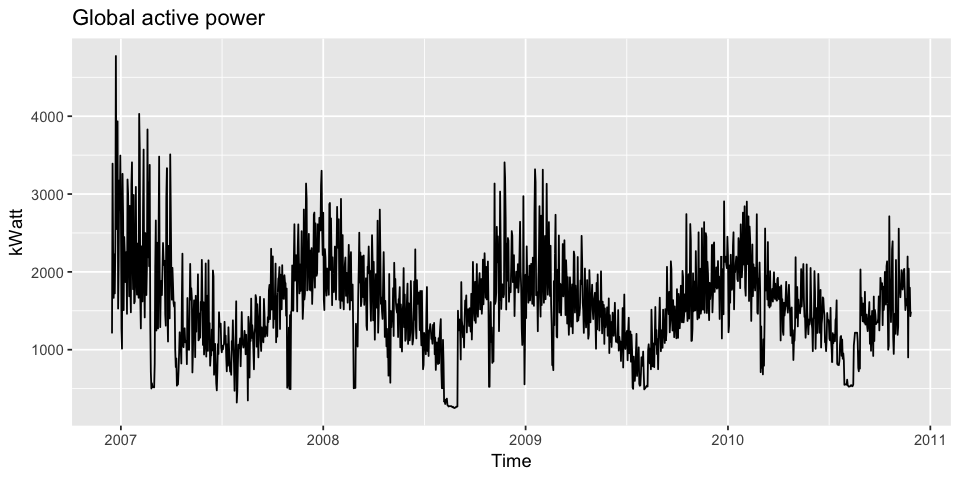

In [8]:
autoplot(power_data) +
    ggtitle('Global active power') +
    ylab('kWatt')

## 3. Train test split

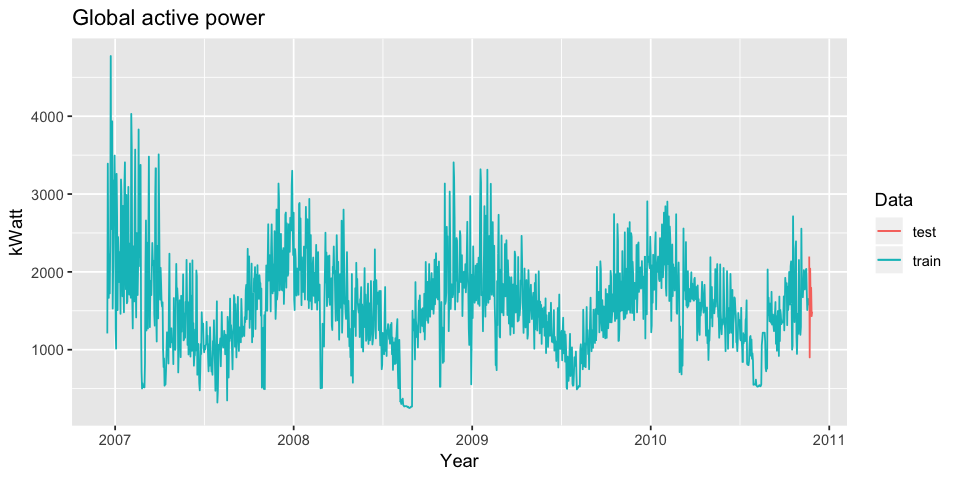

In [13]:
# train and test split
# last four weeks will be test set rest training set
# we will drop the explanatory  variables for baseline models
# as they will not be need for forecasting

test_size <- as.numeric(7*1)
train_size <- nrow(power_data)- test_size

train <- head(power_data, train_size)
test <- tail(power_data, test_size)

autoplot(train, series = 'train') + 
    autolayer(test, series = 'test') +
    ggtitle('Global active power') +
    ylab('kWatt') + 
    xlab('Year') +
    guides(colour=guide_legend(title="Data"))

In [14]:
tail(train)

Time Series:
Start = c(2010, 319) 
End = c(2010, 324) 
Frequency = 365 
     Global_active_power
[1,]            2038.392
[2,]            1747.382
[3,]            1509.748
[4,]            1582.032
[5,]            1652.152
[6,]            1570.400

In [15]:
head(test)

Time Series:
Start = c(2010, 325) 
End = c(2010, 330) 
Frequency = 365 
     Global_active_power
[1,]            2197.006
[2,]             900.910
[3,]            2041.536
[4,]            1577.536
[5,]            1796.248
[6,]            1431.164

In [16]:
tail(test)

Time Series:
Start = c(2010, 326) 
End = c(2010, 331) 
Frequency = 365 
     Global_active_power
[1,]             900.910
[2,]            2041.536
[3,]            1577.536
[4,]            1796.248
[5,]            1431.164
[6,]            1488.104

## 4. Naive method forecasting

In [17]:
# multi-step forecasting using Naive model
naive_multistep <- function(train, test, h=7){
                            n <- length(test)
                            test_pred <- ts(numeric(n), start=c(2010, 325), freq=365)

                            fit <- Arima(train, order = c(0, 1, 0))
                            train_pred <- fitted(fit)

                            for(i in 1:n)
                            {  
                              x <- window(power_data, end=2010 + (318+(i-1))/365)
                              refit <- Arima(x, model=fit)
                              test_pred[i] <- forecast(refit, h=h)$mean[h]
                            }
                            output <- list(train=train_pred, test=test_pred, model=refit)
                            return(output) 
                            }

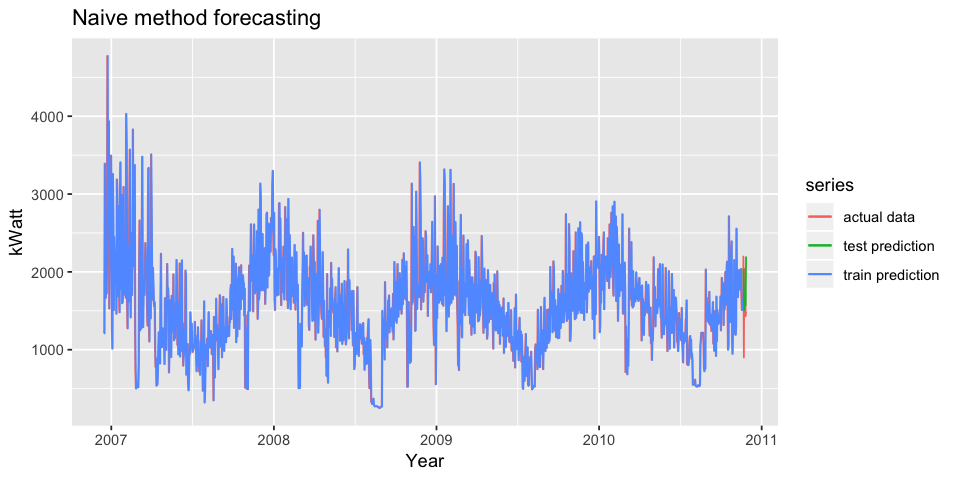

In [18]:
result = naive_multistep(train, test, h=7)

autoplot(power_data, series = 'actual data') +
    autolayer(result$train, series = 'train prediction') +
    autolayer(result$test, series = 'test prediction') +
    xlab('Year') +
    ylab('kWatt') +
    ggtitle('Naive method forecasting')

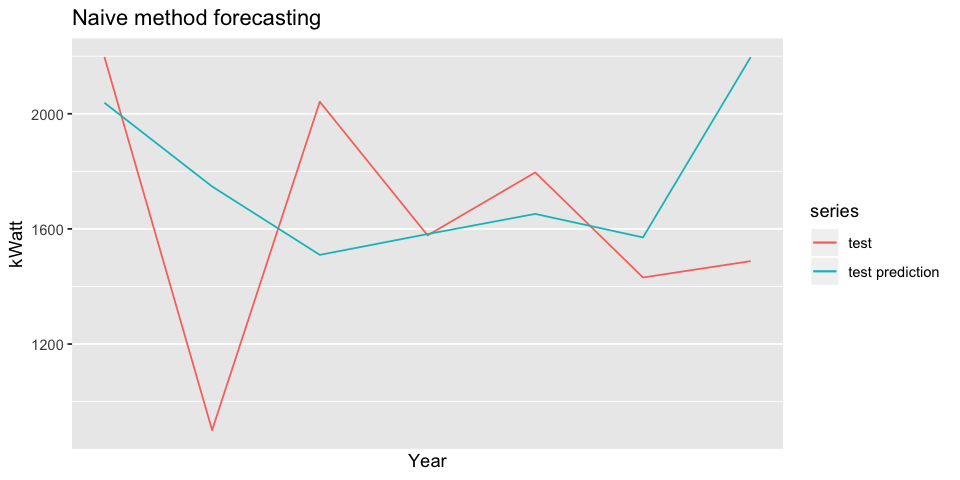

In [22]:
autoplot(test, series = 'test') +
    autolayer(result$test, series = 'test prediction') +
    xlab('Year') +
    ylab('kWatt') +
    ggtitle('Naive method forecasting')

In [19]:
train_pred <- result$train
test_pred <- result$test

train_rmse <- sqrt(mse(train, train_pred))
train_mae <- mae(train, train_pred)
train_nrmse <- train_rmse/sd(train)


test_rmse <- sqrt(mse(test, test_pred))
test_mae <- mae(test, test_pred)
test_nrmse <- test_rmse/sd(test)

print(paste0('Training RMSE :', round(train_rmse, 3)))
print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

print(paste0('Test RMSE :', round(test_rmse, 3)))
print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training RMSE :527.637"
[1] "Training NRMSE :0.882"
[1] "Training MAE :384.601"
[1] "Test RMSE :473.163"
[1] "Test NRMSE :1.099"
[1] "Test MAE :361.943"


## 5. Seasonal naive forecasting

In [23]:
# multi-step forecasting using Seasonal naive model
snaive_multistep <- function(train, test, h=7){
                            n <- length(test)
                            test_pred <- ts(numeric(n), start=c(2010, 325), freq=365)

                            fit <- Arima(train, order = c(0, 0, 0), 
                                         seasonal = list(order = c(0, 1, 0)))
                            train_pred <- fitted(fit)

                            for(i in 1:n)
                            {  
                              x <- window(power_data, end=2010 + (318+(i-1))/365)
                              refit <- Arima(x, model=fit)  
                              test_pred[i] <- forecast(refit, h=h)$mean[h]
                            }
                            output <- list(train=train_pred, test=test_pred, model=refit)
                            return(output) 
                            }

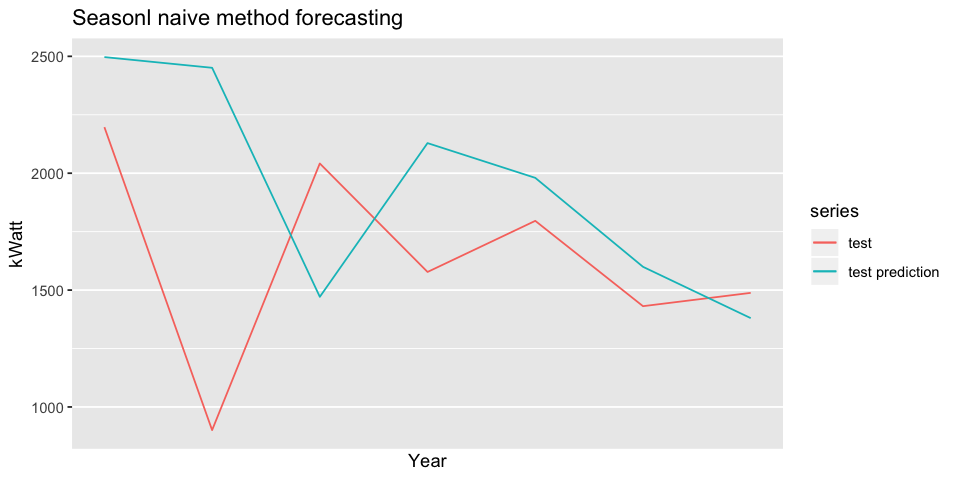

In [24]:
result = snaive_multistep(train, test, h=7)

autoplot(test, series = 'test') +
    autolayer(result$test, series = 'test prediction') +
    xlab('Year') +
    ylab('kWatt') +
    ggtitle('Seasonl naive method forecasting')

In [20]:
train_pred <- result$train
test_pred <- result$test

train_rmse <- sqrt(mse(train, train_pred))
train_mae <- mae(train, train_pred)
train_nrmse <- train_rmse/sd(train)


test_rmse <- sqrt(mse(test, test_pred))
test_mae <- mae(test, test_pred)
test_nrmse <- test_rmse/sd(test)

print(paste0('Training RMSE :', round(train_rmse, 3)))
print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

print(paste0('Test RMSE :', round(test_rmse, 3)))
print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training RMSE :542.554"
[1] "Training NRMSE :0.866"
[1] "Training MAE :346.306"
[1] "Test RMSE :454.903"
[1] "Test NRMSE :1.057"
[1] "Test MAE :341.228"


## 6. Random walk with drift forecasting

In [25]:
# multi-step forecasting using Random walk with Drift
rwf_multistep <- function(train, test, h=7){
                        n <- length(test)
                        test_pred <- ts(numeric(n), start=c(2010, 325), freq=365)

                        fit <- Arima(train, order = c(0, 1, 0), include.drift=TRUE)
                        train_pred <- fitted(fit)

                        for(i in 1:n)
                        {  
                          x <- window(power_data, end=2010 + (318+(i-1))/365)
                          refit <- Arima(x, model=fit)
                          test_pred[i] <- forecast(refit, h=h)$mean[h]
                        }
                        output <- list(train=train_pred, test=test_pred, model=refit)
                        return(output) 
                        }

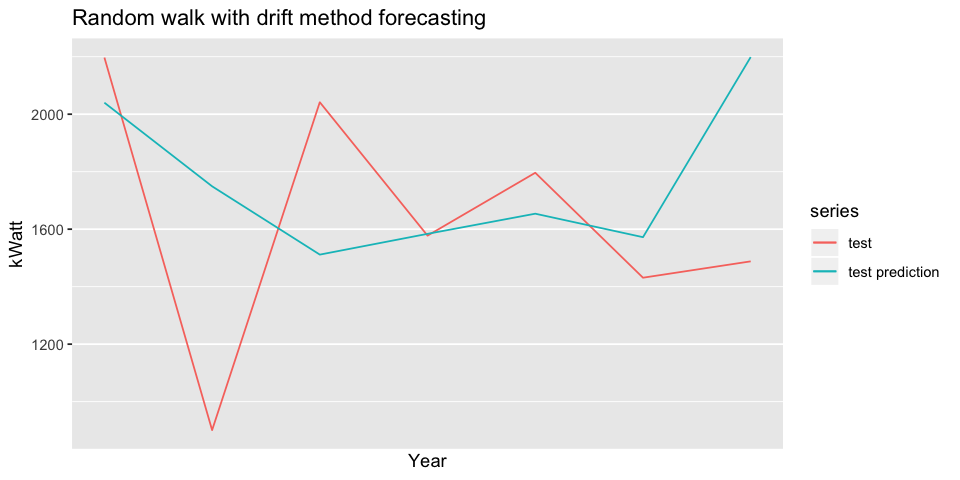

In [26]:
result = rwf_multistep(train, test, h=7)

autoplot(test, series = 'test') +
    autolayer(result$test, series = 'test prediction') +
    xlab('Year') +
    ylab('kWatt') +
    ggtitle('Random walk with drift method forecasting')

In [27]:
train_pred <- result$train
test_pred <- result$test

train_rmse <- sqrt(mse(train, train_pred))
train_mae <- mae(train, train_pred)
train_nrmse <- train_rmse/sd(train)


test_rmse <- sqrt(mse(test, test_pred))
test_mae <- mae(test, test_pred)
test_nrmse <- test_rmse/sd(test)

print(paste0('Training RMSE :', round(train_rmse, 3)))
print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

print(paste0('Test RMSE :', round(test_rmse, 3)))
print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training RMSE :527.637"
[1] "Training NRMSE :0.882"
[1] "Training MAE :384.6"
[1] "Test RMSE :473.627"
[1] "Test NRMSE :1.1"
[1] "Test MAE :362.195"


## Combined plots

In [ ]:
# autoplot(train, series = 'train') +
#     autolayer(test, series = 'test') +
#     autolayer(fitted(rwf_model), series = 'rwf-train') +
#     autolayer(rwf_frcst$mean, series = 'rwf-test') +
#     autolayer(fitted(snaive_model), series = 'snaive-train') +
#     autolayer(snaive_frcst$mean, series = 'snaive-test') +
#     autolayer(fitted(naive_model), series = 'naive-train') +
#     autolayer(naive_frcst$mean, series = 'naive-test') +
#     ggtitle('Comparison of naive, snaive and rwf') +
#     xlab('Year') +
#     ylab('kWatt') +
#     guides(colour=guide_legend(title="Forecast"))